![Shipping_Companies](shipping.png)

At the beginning of the Covid-19 pandemic, when many of us began working form home, I set up my "office" in front of a window that faces the street. I quickly noticed a lot of activity in my little cul-de-sac of 10 homes.  Was there an increase in traffic?  How would I know without having data from before quarantine? Did deliveries increase when the U.S. hit it's 2nd (even 3rd) wave of infections?

So I decided to start tracking all the delivery trucks that come to my neighborhood.  This means that I can only count delivery trucks that I see that day. I started collecting food delivery companies like UberEats and DoorDash but it became difficult to tell if it was a delivery or a visitor.

In [160]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Data collection
I set up a Flask app with FastAPI to record deliveries from any device in my home. The data is hosted and served on a Raspberry Pi 3B.

In [183]:
df = pd.read_json("http://192.168.1.37:5001/deliveries", convert_dates=["created_at"])
df_hh = pd.DataFrame(df[~df["Company"].isin(["UberEats", "DoorDash", "Staples", "Jerome's"])])

### Add date parts to the schema
Break the "created" date into days and months

In [185]:
delivery_df = df_hh.copy()
delivery_df = delivery_df.loc[delivery_df["created_at"] < "2021-03-23"]
delivery_df["month"] = delivery_df["created_at"].dt.month
delivery_df["month_name"] = delivery_df["created_at"].dt.month_name()
delivery_df["day"] = delivery_df["created_at"].dt.day_name()
delivery_df["week"] = delivery_df["created_at"].dt.isocalendar().week
delivery_df.tail()

### Delivery Splits
What share did each company take?

#### Q: Does delivery frequency compare to company revenues?
Amazon revenue: $280.5b *

UPS revenue:  $74.1b

FedEx revenue: $69.7b


\* includes all Amazon products

#### A: Not necessarily
It looks like FedEx is more active in my neighborhood than UPS but Amazon is definitely destroying everyone else.

<AxesSubplot:title={'center':'Neighborhood Deliveries'}, ylabel='Delivery %'>

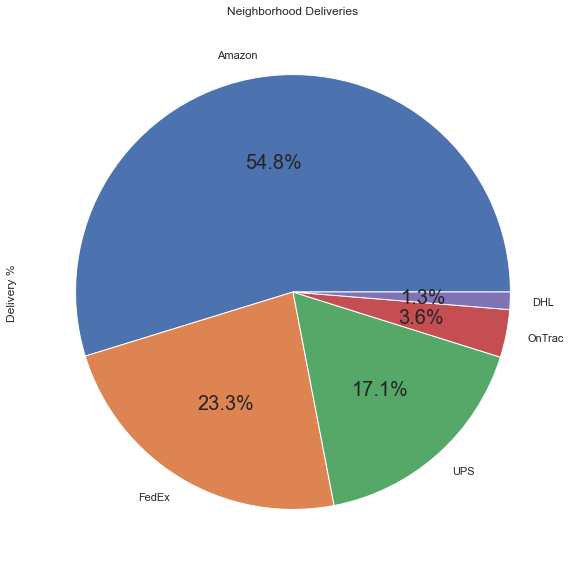

In [191]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["font.size"] = 20
_plot = df_hh.value_counts("Company").plot.pie(y="Company", x="Count", autopct='%1.1f%%', ylabel="Delivery %", title="Neighborhood Deliveries")
_plot

(array([334.,   0., 106.,   0.,   0., 143.,   0.,  22.,   0.,   8.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

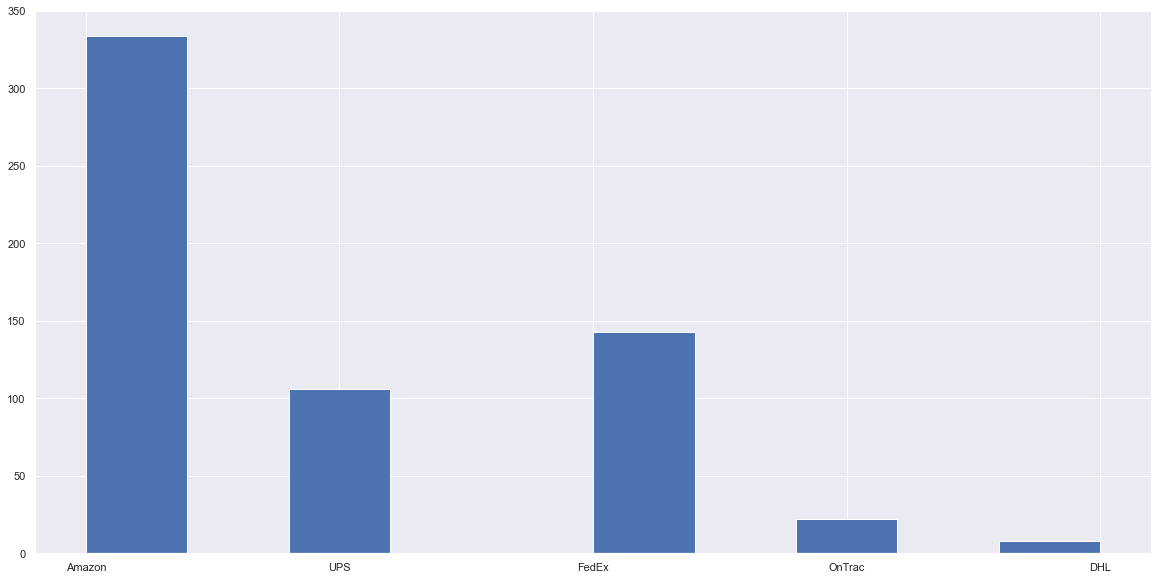

In [190]:
plt.hist(delivery_df["Company"].values)

### My Deliveries
What percentage of deliveries came to my house?

In [180]:
myhouse = delivery_df.value_counts("MyHouse")
pct_myhouse = round(myhouse["Yes"] / myhouse["No"], 2) * 100
print(f"{str(pct_myhouse)}%")

21.0%


### How busy is each day?
Weekdays are definitely the busiest but there is still some considerable traffic on the weekends.

**The following data will contain only Amazon, FedEx and UPS deliveries**

<AxesSubplot:title={'center':'Total deliveries by day of week'}, xlabel='Day', ylabel='Delivery count'>

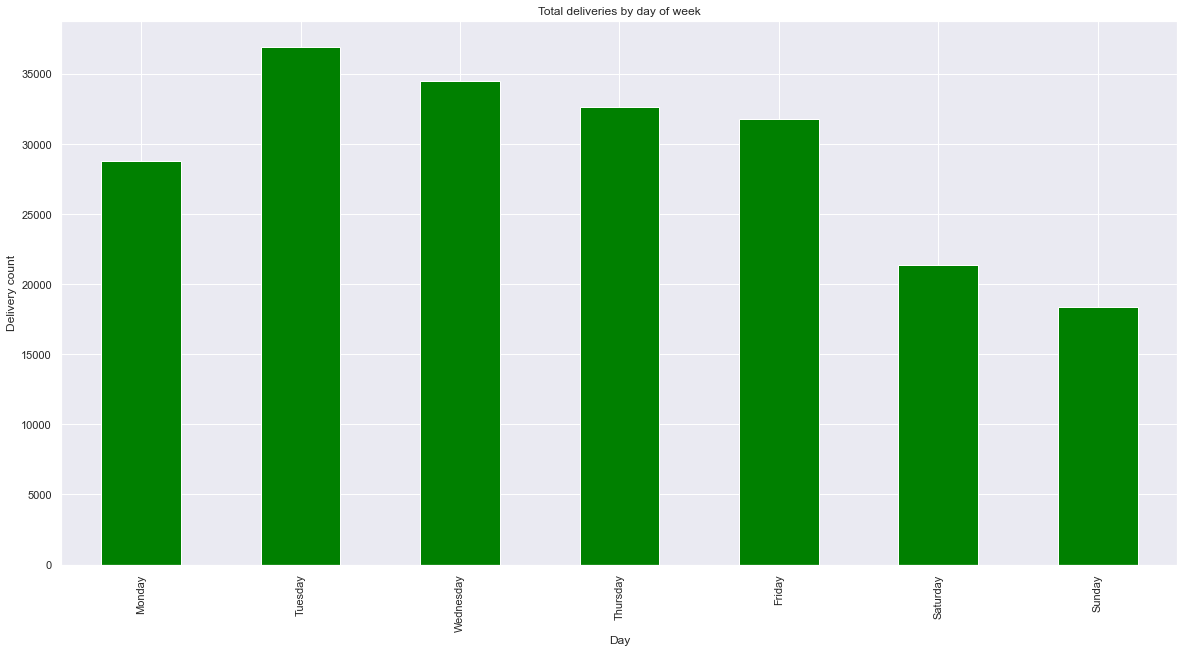

In [187]:
from pandas.api.types import CategoricalDtype
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=days, ordered=True)

day_df = delivery_df.copy()
day_df["day"] = day_df['day'].astype(cat_type)
day_df.groupby("day").count()

day_df["Count"] = day_df["oid"]
day_counts = pd.pivot_table(day_df, values=["Count"], columns=["day"], fill_value=0, aggfunc=np.sum)
day_counts.iloc[0].plot(kind="bar", sort_columns=True, xlabel="Day", ylabel="Delivery count", title="Total deliveries by day of week", color="green")

### Total Deliveries by Month
Distribution of neighborhood deliveries by month

<AxesSubplot:title={'center':'Total deliveries by month'}, xlabel='Month', ylabel='Count'>

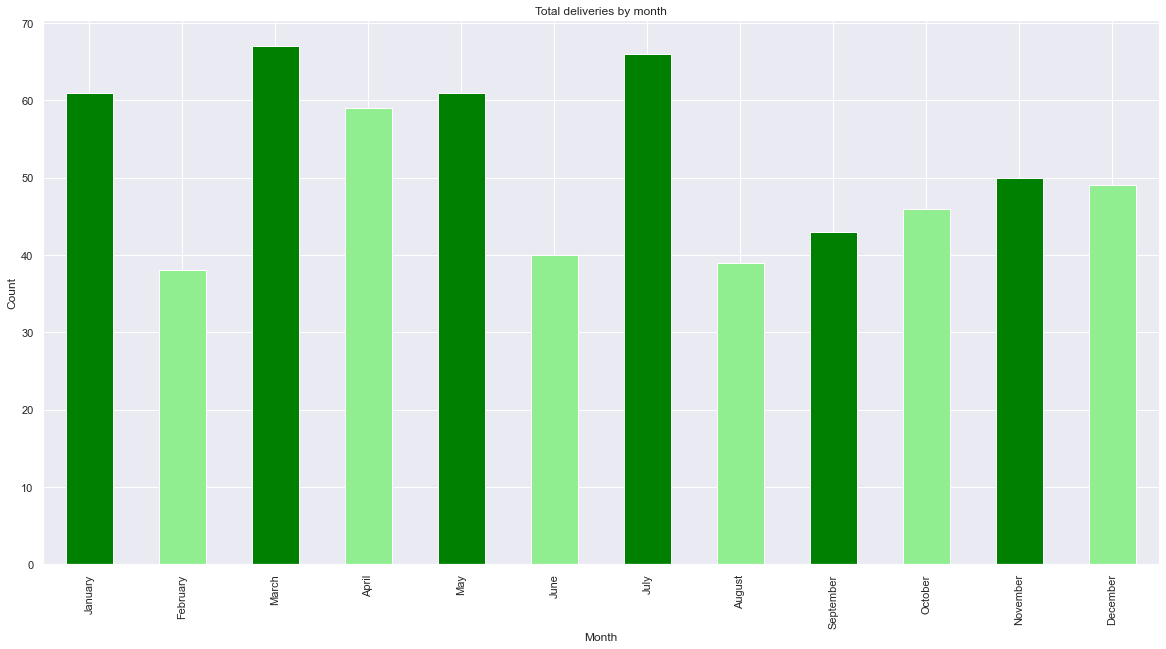

In [186]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
month_df = day_df.groupby("month_name").count()
months_ord = month_df.reindex(months)["Count"]
months_ord.plot.bar(color=["green", "lightgreen"], xlabel="Month", ylabel="Count", title="Total deliveries by month")

### Monthly Deliveries by Company
Distribution of the three main delivery companies by month

In [181]:
def company_month_count(company):
    company_month = delivery_df.loc[df["Company"] == company, ["oid", "month_name", "Company"]].groupby("month_name").count()
    company_month["Count"] = company_month["oid"]
    # Reindex the df to keep month chronology
    months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    return company_month.reindex(months)["Count"]

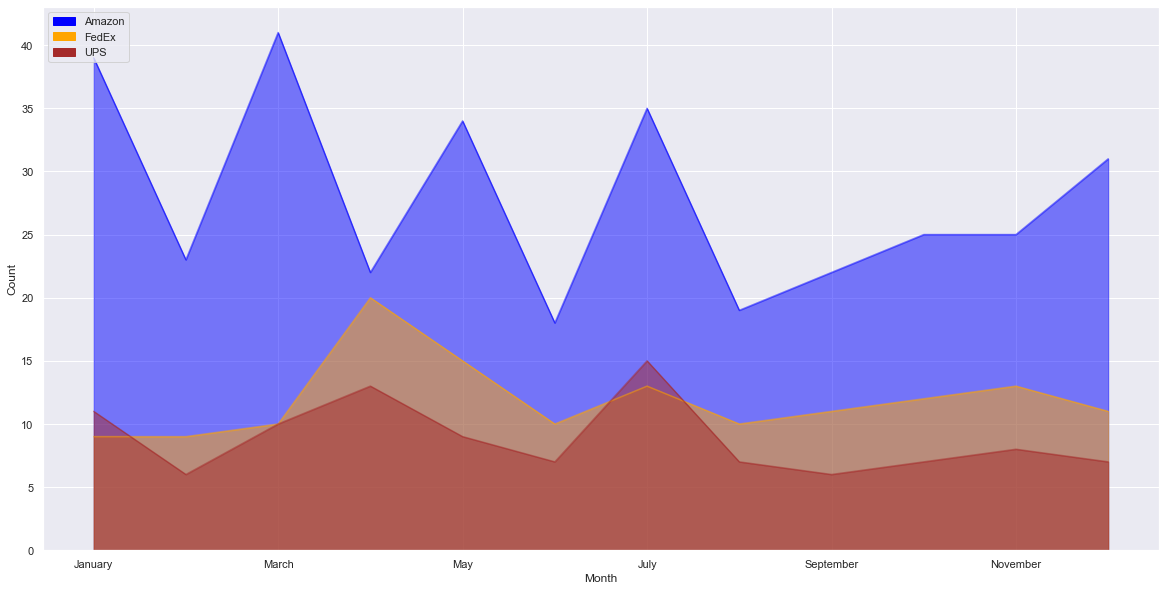

In [182]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
companies = ["Amazon", "FedEx", "UPS"]
colors = ["blue", "orange", "brown"]
AMZN = mpatches.Patch(color='blue', label='Amazon')
FED = mpatches.Patch(color='orange', label='FedEx')
UPS = mpatches.Patch(color='brown', label='UPS')

for i, company in enumerate(companies):
    company_month_count(company).plot(kind="area", xlabel="Month", ylabel="Count", color=colors[i], stacked=False, legend=True)
plt.legend(handles=[AMZN,FED,UPS], loc=2)